In [129]:
# Imports
import json
import os

import numpy as np
import pandas as pd


In [369]:
# Constants
NSHARDS = 10
NUM_INTERVAL = 30
TOP_K = 5

RESULTS_DIR = '/tmp/mwe'
#RESULTS_DIR = '/tmp/mwe_ktrain_1_60'
#RESULTS_DIR = '/tmp/mwe_feat_dis_0.1_0.5'
#RESULTS_DIR = '/tmp/mwe_feat_dis_0_20'
LOCALDIR = '/tmp'

MODELS = ['GCN', 'GraphSAGE']
METRIC = 'test_rocauc_ovr'
#PARAM = 'feature_center_distance'
PARAM = 'p_to_q_ratio'

In [379]:
dfs = []
for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
        lines = f.readlines()
        records = map(json.loads, lines)
        dfs.append(pd.DataFrame.from_records(records))

# Construct df and remove nans
results_df = pd.concat(dfs)
results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
results_df.dropna(axis=0, inplace=True)
del dfs


'''
print(results_df.columns)

feat_list = ["GCN__train_lr","GCN__model_hidden_channels","GCN__model_num_layers","GCN__model_dropout"]
for col in feat_list:
    values = results_df[col].unique()
    for v in values:
        rows = results_df.loc[results_df[col] == v]
        auc_scores = rows['GCN__' + METRIC]
        avg = np.mean(auc_scores)
        var = np.var(auc_scores)
        print('feat: %s, val: %s, num: %s, avg: %.4f, var: %.4f' % (col, v, len(auc_scores), avg, var))
    print()
    print()
    
'''

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


'\nprint(results_df.columns)\n\nfeat_list = ["GCN__train_lr","GCN__model_hidden_channels","GCN__model_num_layers","GCN__model_dropout"]\nfor col in feat_list:\n    values = results_df[col].unique()\n    for v in values:\n        rows = results_df.loc[results_df[col] == v]\n        auc_scores = rows[\'GCN__\' + METRIC]\n        avg = np.mean(auc_scores)\n        var = np.var(auc_scores)\n        print(\'feat: %s, val: %s, num: %s, avg: %.4f, var: %.4f\' % (col, v, len(auc_scores), avg, var))\n    print()\n    print()\n    \n'

In [383]:
columns = results_df.columns

processd_dict = {col : [] for col in columns}

for row in results_df.itertuples():
    param = getattr(row, PARAM)
    len_param = len(param)
    for col in columns:
        val = getattr(row, col)
        if isinstance(val, list):
            processd_dict[col] += val[1:]
        else:
            processd_dict[col] += [val] * (len_param - 1)

processd_df = pd.DataFrame.from_dict(processd_dict)
    
print(len(results_df))
print(len(processd_df))

1000
4000


In [386]:
def process_plot_data(df):

    INTERVAL = (max(df[PARAM]) - min(df[PARAM])) / NUM_INTERVAL

    plot_data = {}
    x_aixs = PARAM
    y_aixs = METRIC + '_drop'
    EPS = 1e-9

    for model in MODELS:
        all_scores = list(df[model + '__' + METRIC])
        group_ids = ((df[PARAM]-min(df[PARAM]) - EPS) / INTERVAL).astype(int)
        group_ids = list(group_ids)

        scores_per_group = {}
        for (i, g_id) in enumerate(group_ids):
            scores_per_group.setdefault(g_id, []).append(all_scores[i])

        sorted_scores_per_group = {}
        for i in sorted (scores_per_group): 
            sorted_scores_per_group[i] = scores_per_group[i]

        group_perf_drop = {}
        group_avg_high_perf = {}
        group_avg_low_perf = {}
        for i in sorted_scores_per_group:
            scores = sorted_scores_per_group[i]
            #print(len(scores))
            sorted_scores = sorted(scores)
            high_scores = sorted_scores[-TOP_K:]
            low_scores = sorted_scores[:TOP_K]
            group_avg_high_perf[i] = np.mean(high_scores) #high_scores #np.mean(high_scores)
            group_avg_low_perf[i] = np.mean(low_scores) #low_scores #np.mean(low_scores)
            group_perf_drop[i] = group_avg_high_perf[i] - group_avg_low_perf[i]   

        x_scale = group_perf_drop.keys()
        #print(x_scale)
        x_index = [(i+1)*INTERVAL for i in x_scale]
        num_x = len(x_scale)
        plot_data.setdefault(x_aixs, [])
        plot_data[x_aixs] += x_index
        plot_data.setdefault(y_aixs , [])
        plot_data[y_aixs] += group_perf_drop.values()
        plot_data.setdefault('model', [])
        plot_data['model'] += [model] * num_x
    return plot_data





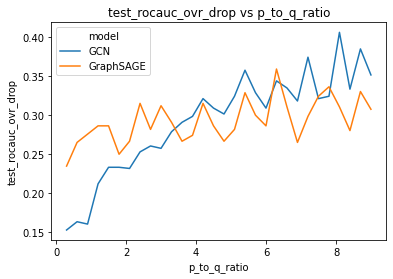

In [387]:
import seaborn as sns

plot_data = process_plot_data(processd_df)
plot_df = pd.DataFrame.from_dict(plot_data)
sns.lineplot(data=plot_df, x=x_aixs, y=y_aixs, hue='model')
plt.title('%s vs %s' % (y_aixs, x_aixs))
plt.show()






